In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.scale
import matplotlib.dates as mdates
import numpy as np
import gdas
import time,math,os,scipy

from datetime             import datetime
from datetime             import timedelta
from scipy                import fftpack,signal,optimize,interpolate

from gwpy.timeseries import TimeSeries,TimeSeriesList
from pycbc import psd,types,filter
from scipy.stats import chi2, chisquare,poisson,norm


import pandas as pd
import timeit
import itertools
import calendar
import random
import copy
from random import shuffle
import seaborn as sns
import matplotlib.cm as cm


from matplotlib import rcParams, cycler

def powerFunc(x, a, b, c): 
    return (a*(x**b) + c)


/home/user/anaconda3/envs/lalsuite-dev/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/home/user/anaconda3/envs/lalsuite-dev/lib/python3.12/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setupto

# Functions:

## Loading and simulating data

In [2]:
#new std load data
def LoadData(start, 
             end,   
             station_list, 
             timeshift = False,
            ):
    
    ''' 
    LoadData gets the magnetic field and sanity data 
    (and optionallly applies a high pass filter) 
    from from all stations in the list station list.
    
    Parameters
    ----------
    start : string
        string representing the start time in the form '%Y-%m-%d-%H-%M'
    end : string
        string representing the end time in the form '%Y-%m-%d-%H-%M'
    station_list : [string]
        list of all stations you want to get data from 


    IMPORTANT NOTE: Load Data will return a separate MASKED ARRAY of the station names
    with the stations that are invalid masked.
    So by using stationArr, you can process data for each station while ignoring the stations with no data
    without changing the number of stations in the list
    so you can assume a certain number and order of stations in the list 
    without knowing ahead of time which ones are active
    '''
    nstations = len(station_list)
    
    dataList = TimeSeriesList()
    sanityList = TimeSeriesList()


    totalTime =  (datetime.strptime(end,'%Y-%m-%d-%H-%M-%S')- datetime.strptime(start,'%Y-%m-%d-%H-%M-%S')).total_seconds()

    starts = [start]
    ends = [end]
    if timeshift:
        starttime = datetime.strptime(start,'%Y-%m-%d-%H-%M-%S')
        endtime = datetime.strptime(end,'%Y-%m-%d-%H-%M-%S')
        
        for i in range(nstations):
            startstme = starttime + timedelta(seconds = i*ShiftTime)
            starts.append(startstme.strftime('%Y-%m-%d-%H-%M-%S'))
            
            endstme = endtime + timedelta(seconds = i*ShiftTime)
            ends.append(datetime.strftime(endstme,'%Y-%m-%d-%H-%M-%S'))     
    else:
        for i in range(nstations):
            starts.append(start) 
            ends.append(end)

    mask = np.zeros(len(station_list))
    stationArr = np.ma.masked_array(np.array(station_list), mask)    

    datapath   = '/mnt/d/AxionAnalysis/'

    for i, station in enumerate(station_list):        
        try:
            if station == 'test':
                data, sanity = GenerateNoise(totalTime, a = 1.0)
            else:
                # use getDataInRange() to get a TimeSeriesList of all the data between start and end
                data1, sanity1,filelist = gdas.getDataInRange(station,starts[i],ends[i], path=datapath, convert = True) 
                # join the individual TimeSeries in the list into a single TimeSeries, representing missing data with NaN
                data = data1.join(pad=float('nan'),gap='pad')
                sanity = sanity1.join(pad=int(0),gap='pad')

#                 station-wise standard devation check    
                if datetime.strptime(start,'%Y-%m-%d-%H-%M-%S').year == 2020:
                    station_set = True
                    if station   == 'berkeley02': 
                        minstdev = 2.
                    elif station == 'berkeley01': 
                        minstdev = 4.
                    elif station == 'daejeon01':
                        minstdev = 0.2
                    elif station == 'hayward01':
                        minstdev = 0.1
                    elif station == 'krakow01': 
                        minstdev = 0.8
                    elif station == 'lewisburg01':  
                        minstdev = 0.1
                    elif station == 'mainz01': 
                        minstdev = 0.1
                    elif station == 'losangeles01': 
                        minstdev = 1.5
                    elif station == 'moxa01':       
                        minstdev = 1.
                    elif station == 'oberlin01':    
                        minstdev = 0.2
                    else: 
                        station_set = False
                        print ("Minimum standard deviation not set for "+station+".")
                    if station_set:
                        for x in range(1,len(data)//(WindowLength*int(FSamp))+1):
                            check_data = data[(x-1)*int(FSamp)*WindowLength:x*int(FSamp)*WindowLength]
                            stdev = np.nanstd(check_data)
                            if stdev < minstdev:
                                sanity[(x-1)*WindowLength:x*WindowLength] = [0]*WindowLength
                                #print ("unreasonably low standard deviation found: ",round(stdev,4)," pT")
                else:
                    print ("Minimum standard deviation not set for " + str(starttime.year) + ".")

            #check to make sure there are enough sane data for analysis
            #Note that requirements are most strict if filtering
            
            assert sanity.value[np.nonzero(sanity.value)].size>0, "no sane data for station {}".format(station)
        
            count = 0
            passing = False
            s=0

            minPassingRun = 60 # at least 1 minute of continuously sane data
           
            while (not passing) and (s < sanity.value.size):
                if sanity[s] >= 1:
                    count += 1
                    s+=1
                    if count >= minPassingRun: 
                        passing = True
                else:
                    count = 0
                    s+=1
            
            #print(station)
            assert passing, "not enough sane data for analysis (< {} consecutive seconds)".format(minPassingRun)
            
            # flag each ±1 s of time series data with the appropriate sanity value
            data_arr = np.copy(data.value)
            sanity_arr = sanity.value
            isSane = np.ones(data_arr.shape)
            isSane[0:int(FSamp)] *= sanity_arr[0]
            for pt, val in enumerate(sanity_arr[1:-1]):
                if val < 0.5: isSane[(pt)*int(FSamp): (pt+2)*int(FSamp)] *= int(val)
            isSane[-int(FSamp):] *= sanity_arr[-1]
            isSane = (isSane-1)*-1
            
            #double check that missing data are flagged as insane
            isSane[np.isnan(data_arr)] = 1
                
            bad = np.nonzero(isSane)[0]

            data_arr[np.nonzero(isSane)] = np.nan
            tme = data_arr.size/FSamp

            if data_arr.size < totalTime*FSamp: 
                print("data size mismatch for station {}, padding end".format(station))
                data_arr = np.pad(data_arr, pad_width = (0, int(totalTime*FSamp) - data_arr.size), mode = 'constant', constant_values = (np.nan,))
                sanity_arr = np.pad(sanity_arr, pad_width = (0, int(totalTime) - sanity.size), mode = 'constant', constant_values = (np.nan,))
                sanity = TimeSeries(sanity_arr, sample_rate = sanity.sample_rate)

            dtimes = np.arange(0, tme, 1./FSamp)
            stimes = np.arange(0,tme)
            data_ts= TimeSeries(data_arr, times = dtimes, sample_rate = data.sample_rate)
            
            dataList.append(data_ts)
            sanityList.append(sanity)
            
        except AssertionError as error:
            stationArr[i] = np.ma.masked
            print(error)
        except:
            raise
    #station_list[:] = stationArr[~stationArr.mask]

    return dataList, sanityList, stationArr, starts, ends
    
    

# Load Time Shuffled Data 

In [3]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def LoadTimeShuffled(ndatesA,
                    fullStationListA,
                    fullUncA,
                    fullSpinCorrA,
                    fullBandCorrA,
                    nstationsavgA,
                    realDataA = True,
                    timeShiftA = False
                    ):

    # randomize list of station names to make full_station_list
    #    full_station_list_2 = random.sample(full_station_list, len(full_station_list))

    templist = list(zip(fullStationListA, fullUncA, fullSpinCorrA, fullBandCorrA)) #Zips station name with uncertainties and corrections 
    random.shuffle(templist) #Suffles list
    fullStationList2, fullUnc2 , fullSpinCorr2, fullBandCorr2 = zip(*templist) #Unzips shuffled list
      
    

    if RealData:
        stationList  = list(fullStationList2)
    else:
        stationList = []
        for i in range(0, numberOfStations): stationList.append('test')        
  
    
    fullUncR      = np.asarray(fullUnc2)
    fullSpinCorrR = np.asarray(fullSpinCorr2)
    fullBandCorrR = np.asarray(fullBandCorr2)
    

    datalistR   = np.empty(ndatesA, dtype = list) #Initialize data list
    sanitylistR = np.empty(ndatesA, dtype = list) #Initialize sanity list
    startTimes  = np.empty(ndatesA, dtype = list)
    endTimes    = np.empty(ndatesA, dtype = list)
    


    stationsR = np.empty(ndatesA, dtype = np.ma.masked_array)

    for j in range(ndatesA):

        datalistR[j], sanitylistR[j], stationsR[j], startTimes[j], endTimes[j] = LoadData(windowStarts[j], 
                                                                                  windowEnds[j],
                                                                                  stationList, 
                                                                                  timeshift = timeShiftA
                                                                                  )

        if realDataA:
            nstationsavgA += np.ma.count(stationsR[j])
            nstationsavgR = nstationsavgA 
        else:
            nstationsavgR = numberOfStations
            stationListTemp   = intersection(fullStationList2, fullStationListA[0:numberOfStations])


            temp = np.ma.masked_array(np.array(fullStationList2), np.zeros(len(fullStationList2))) 
            for t,station in enumerate(fullStationList2):
                if station not in stationListTemp:
                    temp[t] = np.ma.masked          

            stationsR[j] = temp            

            
            
            
    if realDataA:
        nstationsavgR = np.int64(nstationsavgR/ndatesA)   
            
    
    return datalistR, sanitylistR, fullUncR, fullSpinCorrR , fullBandCorrR, stationsR, nstationsavgR, startTimes, endTimes


# Functions to Generate Gaussian Data

In [4]:

# Functions to generate Gaussian Noise time series, one with just noise and the other with a signal burst

def GenerateNoise(l, a = 1.): #l = total time in seconds
    x=np.arange(0.,float(l),1./FSamp)
    y= a*np.random.normal(loc=0,size=x.size)

    GenNoise = TimeSeries(y, sample_rate = FSamp)
    SanityNoise = TimeSeries(np.ones(int(l)), sample_rate = 1.)
    
    return GenNoise, SanityNoise


def GenerateDataBurst(data_ts, a, k, dur, burstStart):
    '''
    Injects a sinusoidal burst into an existing time series.   
    Parameters
    ----------
    data_ts : TimeSeries
        time series in which you want to inject the signal
    a : float
        burst ampl [pT] 
    k : float
        burst frequency [Hz]
    dur : int
        burst duration [s]
    burstStart : int
        start time for the burst [s]
    '''

    s = data_ts.size/FSamp
    x = np.arange(0.,s,1./FSamp)
    burst = a*np.sin(2.*np.pi*k*x)
    data_arrA = np.copy(data_ts.value)
    assert(burstStart<=s), "invalid start time value for injected burst (only {} seconds of data)".format(s)
    endt = burstStart+dur
    if endt > s:
        endt = s
    data_arrA[int(np.round(burstStart*FSamp)):int(np.round(endt*FSamp))] = data_arrA[int(np.round(burstStart*FSamp)):int(np.round(endt*FSamp))]+burst[0:int(np.round(dur*FSamp))] 
    
    dataBurst = TimeSeries(data_arrA, sample_rate = FSamp)
    return dataBurst





def insertEvent(station_listA, ts_listA, durationA, freqA, RA, thetaA, phiA, starttA = 500, degreesA = True):
    newListR = TimeSeriesList()
    
    if degreesA:
        thetaA = thetaA*(np.pi/180.)
        phiA = phiA*(np.pi/180.)
        
        
        xdir = RA*np.sin(phiA)*np.cos(thetaA)
        ydir = RA*np.sin(phiA)*np.sin(thetaA)
        zdir = RA*np.cos(phiA)
        
    else:
        xTemp = random.uniform(-1, 1)
        yTemp = random.uniform(-1, 1)
        zTemp = random.uniform(-1, 1) 
        tempNorm = np.sqrt((xTemp)**2 + (yTemp)**2 + (zTemp)**2)
        xdir = RA*(xTemp/tempNorm)
        ydir = RA*(yTemp/tempNorm)
        zdir = RA*(zTemp/tempNorm)


        
        
#     print ("!!!!@@@",RA,(xdir**2 + ydir**2 + zdir**2) )



    bx, by, bz = initializeVectorSpace(station_listA)
    amplitudesR = xdir*bx + ydir*by + zdir*bz
    propVectR = np.array([xdir,ydir,zdir])
    #print("\nPropagation vector: {} \ninjected amplitudes: \n{}".format(np.round([xdir,ydir,zdir], 4), np.round(amplitudes, 6)))

    for ts, ampA in zip(ts_listA, amplitudesR):
        newListR.append(GenerateDataBurst(ts, a = ampA, k = freqA, dur = durationA, burstStart =starttA))

    return newListR, amplitudesR,propVectR


## Plotting Functions

In [5]:
def show_initial_spec(ep_stationA,txA,fxA,SxxA,logplotA, normalized = False):
    
    f0, ax = plt.subplots(1,figsize=(9,5))
    if logplotA == True:
        im = ax.pcolormesh(txA,fxA,SxxA,norm = matplotlib.colors.LogNorm())
    else:
        im = ax.pcolormesh(txA,fxA,SxxA)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('freq (Hz)')
    ax.set_yscale('symlog', nonposy = 'clip')
    if normalized:
        ax.set_title(str(ep_stationA)+' Whitened Spectrogram Before Summing Tiles')
    else:
        ax.set_title(str(ep_stationA)+' Unwhitened Spectrogram Before Summing Tiles')
    
    ax.grid(False)
    f0.colorbar(im, ax=ax)
    plt.show()
    
def show_avg_psd(ep_stationA,fxA,SkA):
        
    plt.title(str(ep_stationA)+" Average PSD")
    plt.ylabel("average PSD")
    plt.xlabel("frequency")
    plt.plot(fxA,SkA)
    plt.yscale('log',nonposy = 'clip')
    plt.show()
    
    
def plotEventMap(eventSpec0A, TLimitA, tTileWidthA, stageA):
    
    ts = np.arange(0., TLimitA, tTileWidthA)
    figure, ax1 = plt.subplots(1, figsize = (8,4))
    im = ax1.pcolormesh(ts, fs, eventSpec0A)
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('freq (Hz)')
    ax1.set_yscale('symlog',nonposy = 'clip')  
    ax1.set_title('stage '+ stageA + ' flagged events')
    ax1.colorbar(im)
    plt.show()
                
def plotSummedSpec(stationA, tSDataA, tF0A, tLimitA, nTTilesA, deltaTA, bwlimA, nChanA , deltaFA, logplotA):
    
    tx1 = np.linspace(0, tLimitA, nTTilesA + 1)
    fx1 = np.linspace(deltaFA, bwlimA, int(nChanA))    
    f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[4,1]},figsize=(9,6),sharex=True)
    tme = np.linspace(0,tLimitA,np.size(tSDataA))
    a1.plot(tme,tSDataA)
    if logplotA == True:
        im1 = a0.pcolormesh(tx1,fx1,2.*tF0A, norm = matplotlib.colors.LogNorm())
    else:
        im1 = a0.pcolormesh(tx1,fx1,2.*tF0A)
    a1.set_xlabel('time (s)')
    a1.set_ylabel('amplitude (pT)')
    a0.set_ylabel('freq (Hz)')
    a0.set_yscale('symlog',nonposy = 'clip')
    a0.grid(False)
    a0.set_title(str(stationA)+' Excess Power: Delta T = '+ str(deltaTA)+' s. Delta f = '+ str(deltaFA)+' Hz. ')
    axs = [a0,a1]
    f.colorbar(im1,ax=axs)
    plt.show()
    
def plotTimeSeries(stationA, tSDataA, tLimitA, startTimeA, endTimeA):
    
    tme = np.linspace(0, tLimitA, np.size(tSDataA))
    figure, ax = plt.subplots(1, figsize = (8,4))
    ax.plot(tme,tSDataA)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('amplitude (pT)')
    plt.show()
    
def plotAllTimeSeries(stationsA, datalistsA, tLimitA, startTimesA, endTimesA):
    
    numStations = np.size(stationsA)
    timeStart = []
    timeStart = [i*ShiftTime for i in range(numStations)]
    timeEnd = []
    timeEnd = [i*ShiftTime + tLimitA for i in range(numStations)]
    
    vertOffset = []
    vertOffset = [i*100 for i in range(numStations)]
    #vertOffset = [0,25,50,75,125,250]
    
    figure, ax = plt.subplots(1, figsize = (8,4))
    
    for i in range(np.size(active)):
        tme = np.linspace(timeStart[i], timeEnd[i], np.size(datalistsA[0]))
        ax.plot(tme, datalistsA[i]-np.mean(datalistsA[i])-vertOffset[i], label = stationsA[i])
        ax.legend()
    
    ax.set_xlabel('time (s)')
    ax.set_ylabel('amplitude (pT)')
    plt.show()

def plotAllPSDs(stationsA, fxA, Sk_normedA):
    
    numStations = np.size(stationsA)
    
    for i in range(numStations):
        plt.plot(fxA, Sk_normedA, label = stationsA[i])
        plt.legend()
    
    plt.title(str(ep_stationA)+" Average PSD")
    plt.ylabel("average PSD")
    plt.xlabel("frequency")
    plt.yscale('log',nonposy = 'clip')
    plt.show()

In [6]:
#plotAllTimeSeries(active, datalist[0], TLimit, startTimes[0], endTimes[0])

## Get chisquared value

In [7]:
def GetChisqr(ep_array, 
              dt, 
              df, 
              binw = 60, 
              log = False,
              showplot = True,
    ):
    
    dof = 2.0*dt*df
    Mvals=np.reshape(ep_array,-1);    
    hist, x = np.histogram(Mvals, bins = binw, density = False) 
    nbins = x.size-1
    binwidth = x[1]-x[0]    
    binscenter = x[1:]-binwidth/2
    y = chi2.pdf(binscenter, dof, loc = 0)
    sigma_hist = np.sqrt(hist)
    
   
    normalize = np.sum(hist*binwidth)
    hist_normed = hist/normalize
    sigma_normed = sigma_hist/normalize
    hist_norm_nz = hist_normed[np.nonzero(hist_normed)]
    sigma_norm_nz = sigma_normed[np.nonzero(hist_normed)]
    y_nz = y[np.nonzero(hist_normed)]
    x_nz = binscenter[np.nonzero(hist_normed)]
    
    chisqrd = np.sum(((hist_norm_nz-y_nz)/sigma_norm_nz)**2.0)
    reduced_chisqrd = chisqrd/(hist_norm_nz.size)
        
    if showplot:        
        f, (ax0,ax1) = plt.subplots(2, figsize= (10,8))
        ax0.hist(Mvals, bins = nbins, density = True)
        ax0.errorbar(binscenter, hist_normed, yerr = sigma_normed, fmt = '.')
        ax1.hist(Mvals, bins = nbins, density = True)
        ax1.errorbar(binscenter, hist_normed, yerr = sigma_normed, fmt = '.')
        ax1.semilogy(binscenter,y,'r-', label ='Chi-Square dist (dof = {}) \n $\delta t$: {} s \n $\delta f$: {} Hz'.format(dof, dt, df))
        ax0.plot(binscenter,y,'r-', label ="Chi-Square dist (dof = {}) \n $\delta t$: {} s \n $\delta f$: {} Hz \n reduced $\chi^2$: {}".format(dof, dt, df,reduced_chisqrd))
        ax0.set_xlabel('$\chi^2$')
        ax0.set_ylabel('Probability density')  
        ax0.legend()
        ax1.set_xlabel('$\chi^2$')
        ax1.set_ylabel('Probability density')  
        ax1.legend()
        plt.show()
    return reduced_chisqrd

<>:36: SyntaxWarning: invalid escape sequence '\d'
<>:37: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\c'
<>:41: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\d'
<>:37: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\c'
<>:41: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1232041/1472737293.py:36: SyntaxWarning: invalid escape sequence '\d'
  ax1.semilogy(binscenter,y,'r-', label ='Chi-Square dist (dof = {}) \n $\delta t$: {} s \n $\delta f$: {} Hz'.format(dof, dt, df))
/tmp/ipykernel_1232041/1472737293.py:37: SyntaxWarning: invalid escape sequence '\d'
  ax0.plot(binscenter,y,'r-', label ="Chi-Square dist (dof = {}) \n $\delta t$: {} s \n $\delta f$: {} Hz \n reduced $\chi^2$: {}".format(dof, dt, df,reduced_chisqrd))
/tmp/ipykernel_1232041/1472737293.py:38: SyntaxWarning: invalid escape sequence '\c'
  ax0.set_xlabel('$\chi^2$')
/tmp/ipy

In [8]:
def EPcutoff(EPspect, thold):
    """ Given a matrix EP and a threshold thold, this function returns all the element greater than the threshold."""   
    EPspect2 = np.zeros(EPspect.shape)
    EPspect2[EPspect > thold] = 1
    return EPspect2

In [9]:
#Function that is solved by finding its roots to determine the values of x that give a prob. of chi^2 > beta
def betart(x, dof, beta):
    return scipy.integrate.quad(chi2.pdf, x, np.inf, args = dof)[0] - beta

#Function accounts for the possible combinations given the number of stations number of coincidences required
def betacomb(p,Nst,nCoinA,beta):
    q = -beta
    for i in range(nCoinA, Nst):
        q += scipy.special.binom(Nst, i)*(p**i)*((1-p)**(Nst-i))
    return q 

def calcmulti(Nst, nCoinA = 3, beta = 2.7*10.**-7):
    sol = scipy.optimize.fsolve(betacomb, beta, args = (Nst, nCoinA, beta))
    return sol

#Calculates the excess power above which the tail has a fractional probability of betaA assuming Gaussian noise. 
#The sigma is just used to estimate the starting guess for fsolve.
def calculatecutoff(dofA, NstA, nCoinA = 4, betaA = 2.7*10.**-7, sigmaA = 5. ):
    beta2 = calcmulti(NstA, nCoinA, betaA)
    sol = scipy.optimize.fsolve(betart, dofA+sigmaA*np.sqrt(2.*dofA), args = (dofA, beta2))
    return sol


#Returns the probability for finding an excess power larger than ep_star for a given dof, number pf stations and number of coincidences 
def Q0(ep_star, dof, Nst, nCoinA): 
    q = 0
    p = scipy.integrate.quad(chi2.pdf, ep_star, np.inf, args = dof)[0]
    for i in range(nCoinA, Nst+1):
        q += scipy.special.binom(Nst, i)*(p**i)*((1-p)**(Nst-i))
    return q

def generateThresholds(tsumsA, chanPerTileA, nstationsavgA, nCoinA=4, betaA=0.003, sigmaA = 3.):
    
    #Calculates the EP value so that the area of the tail of the associated prob. dist. has a probabilty of beta for each number of tiles summed
    #Takes into account the coincidence of the stations
    
    # Set initialize the EP thresholds array that will be used
    thresholdsR = np.zeros((ntsums, nThreshs))

    for i,n in enumerate(np.arange(imint,imaxt+1,1)):
        thresholdmax = thresholdmaxs[n]
        thresholdmin = thresholdmins[n]
        #Creates a list of excess power thresholds at which the false prob will be calcuated; nt=number of thresholds
        thresholdsR[i,:] = np.linspace(thresholdmin, thresholdmax, nThreshs) 
    return thresholdsR

## Consistency check functions

In [10]:
def initializeVectorSpace(stationlist, gs = False,testing = False):

    # The gs arguement squares the amplitude projections. This might be because we are detecting power, 
    # but it is being called with gs=False, currently.
    
    numstations = len(stationlist)
    # (Latitude, Longitude, Azimuth(0 north, 90 east, 180 south, 270 west), Altitude(0 horizon, 90 zenith))
    
    stationDict  = {
        'beijing01': (40.2, 116., 251., 0.), 
        'berkeley01': (37.9, -122., 28., 0.),
        'berkeley02':(37.9, -122., 0., 90.),
        'canberra01': (-35.3, 149, 0., 0.),
        'daejeon01': (36.2, 127., 0., 90.),
        'fribourg01': (46.8, 7.16, 190., 0.),
        'hayward01': (37.7, -122., 0., -90.),   
        'hefei01': (31.8, 117., 90., 0.),
        'krakow01':(50.0, 19.9, 45., 0.),
        'lewisburg01': (41.0, -76.9, 0., 90.),    
        'losangeles01':(34.1, -118., 270., 0.),
        'mainz01': (50.0, 8.25, 0., -90.),    
        'oberlin01': (41.2, -82.1, 300., 0.),
        'stuttgart01':(48.7, 9.10, 0., 0.),
        'moxa01':(50.6, 11.6, 270., 0.)
        }
     
    latitude = np.zeros(numstations)
    longitude =  np.zeros(numstations)
    azimuth =  np.zeros(numstations)
    altitude =  np.zeros(numstations)
    directionmat = np.zeros((numstations, 3))
    for i,station in enumerate(stationlist):
        location = stationDict.get(station)
        latitude[i] = (location[0])
        longitude[i] = (location[1])
        azimuth[i] = location[2]
        altitude[i] = location[3]
        
        #Create a direction matrix consisiting of the (x,y,z) direction of sensitive axis in Earth-centered frame
        directionmat[i] = xyzCoordinates(latitude[i], longitude[i], azimuth[i], altitude[i])
    
    directionmat[np.abs(directionmat) < (10.**(-10))] = 0.0
    xSignal = directionmat[:,0]
    ySignal = directionmat[:,1]
    zSignal = directionmat[:,2]
    
    if gs:
        xSignal = directionmat[:,0]**2
        ySignal = directionmat[:,1]**2
        zSignal = directionmat[:,2]**2
        xnorm = np.linalg.norm(xSignal)
        ynorm = np.linalg.norm(ySignal)
        znorm = np.linalg.norm(zSignal)    
        if xnorm > 0.: xSignal = xSignal/np.linalg.norm(xSignal)
        if ynorm > 0.: ySignal = ySignal/np.linalg.norm(ySignal)
        if znorm > 0.: zSignal = zSignal/np.linalg.norm(zSignal)

        ySignal = ySignal - (np.dot(xSignal, ySignal)*xSignal)
        ynorm = np.linalg.norm(ySignal)
        if ynorm > 0.: ySignal = ySignal/ynorm

        zSignal = zSignal - np.dot(ySignal, zSignal)*ySignal - np.dot(xSignal, zSignal)*xSignal
        znorm = np.linalg.norm(zSignal)
        if znorm > 0.: zSignal = zSignal/znorm  
        
    return xSignal, ySignal, zSignal

In [11]:
# Function returns the direction of the sensitive axis in a (x,y,z) coordinates for Earth centered frame.
# x axis goes through Longitude = 0
# y axis goes through longitude = 90
# z axis goes through latitude = 90 (i.e the north pole)

#Check the azimuth

def xyzCoordinates(lat, lon, az, alt):
    # station location in spherical coordinates 
    # (math convention theta from x, phi from z)
    Ltheta = (lon)*np.pi/180.
    Lphi = (90. - lat)*np.pi/180.
    Lr = 1.0

    # station location in cartesian coordinates (wrt the center of the earth)
    Lx = Lr*np.sin(Lphi)*np.cos(Ltheta)
    Ly = Lr*np.sin(Lphi)*np.sin(Ltheta)
    Lz = Lr*np.cos(Lphi)
    L = np.array([Lx, Ly, Lz])

    # calculate North direction vector:
    Nx = -Lx
    Ny = -Ly
    Nz = (Lx**2.+Ly**2.)/Lz
    
    # normalizing 
    Nmag = np.sqrt(Nx**2.+Ny**2.+Nz**2.) 
    Nx = Nx/Nmag
    Ny = Ny/Nmag
    Nz = Nz/Nmag
    N = np.array([Nx, Ny, Nz])

    # calculate West direction vector ((N,W,L) analogous to (x, y, z)):
    W = np.cross(L,N, axisa = 0, axisb = 0, axisc = 0)
    Wx = W[0]
    Wy = W[1]
    Wz = W[2]
    
    # L dot v = Lv cos phi = cos phi
    # N dot v = Nv cos theta = cos theta
    
    # sensitive axis in (r', theta', phi') coordinates (centered on station)
    phip = (90.-alt)*np.pi/180.    
    thetap = -az*np.pi/180.   
    rp = 1.0

    vN = rp*np.sin(phip)*np.cos(thetap)
    vW = rp*np.sin(phip)*np.sin(thetap)
    vL = rp*np.cos(phip)  
    vp = [vN, vW, vL]
    
    R = np.array([[Nx, Wx, Lx], [Ny, Wy, Ly], [Nz, Wz, Lz]])

    direction = np.matmul(R, vp) 
    direction[np.abs(direction) < (10.**(-10))] = 0.0
    
    directionnorm = np.linalg.norm(direction)
    if directionnorm > 0: direction = direction/directionnorm

    return direction

## Spectrogram Functions

In [ ]:
#Takes spectrogram and sums time tiles, there is no frequency summing
#Returns both normalized and unnormalized spectrograms with the time tiles summed

def EP0(ts_data,
        segments_per_tile = 1,
        channels_per_tile = 1,
        deltaTMinA = 1.0,
        ep_station = 'test',
        bwlim = 100.0,
        window = 'boxcar', 
        makeplot = False,
        show_intermediate = False,
        logplot = True
        ):
      
    deltaTMinA = float(deltaTMinA)   
    tLim = np.size(ts_data)/FSamp #Defines the time length of the data set
    n_samp_per_seg = int(deltaTMinA * FSamp)    # number of samples in one time segment
    
    ####################################################################################
    #Below is the code for generating overlapping windows. Only the boxcar is being used
    dtoverlap = 0
    deltaToverlap = 0.0

    if window == 'hann': 
        deltaToverlap = deltaTMinA/2
        dtoverlap = int(n/2)
        
    elif window == 'boxcar':
        dtoverlap = 0
        deltaToverlap = 0.0
    
    elif window == 'tukey': 
        window = ('tukey',0.25)   
        dtoverlap = int(n_samp_per_seg/8)
        deltaToverlap = dtoverlap/FSamp
    
    else: 
        print("window changed to boxcar window")
        window = 'boxcar'   

    ###################################################################################    
    data_arr = np.array(ts_data.value) #make array of the time series
    
    #time:
    total_size = data_arr.size   
    nsegments = int((total_size - dtoverlap) / (n_samp_per_seg - dtoverlap)) 
    nTtiles = int(nsegments/segments_per_tile)
    deltaT = segments_per_tile*deltaTMinA
    segments_per_tile = int(segments_per_tile)
    
    #frequency:
    bwlimidx = int((bwlim * deltaTMinA) + 1)
    deltaF = 1./deltaTMinA*channels_per_tile
    channels_per_tile = int(channels_per_tile)
    
    #get spectrogram with time step deltaTmin (no tile summing). 
    #The rows of Sxx are the frequencies and the columns the time segments
    fx,tx,Sxx = signal.spectrogram(data_arr,
                                   fs = FSamp,
                                   nperseg = n_samp_per_seg,
                                   noverlap = dtoverlap,
                                   scaling ='spectrum',
                                   mode = 'psd',
                                   window = window)
        
#         print("Length of fx: {}".format(np.size(fx)))
#         print("Number of rows for Sxx: {}".format(len(Sxx)))
#         print("Number of columns for Sxx: {}".format(len(Sxx[0])))
    
    #Reshape spectrogram to exclude frequencies above the bandwidth limit, bwlim
    Sxx = Sxx[1:bwlimidx,:]
    fx = fx[1:bwlimidx]
    
    if show_intermediate: #this is the initial spectrogram with no tiles summed and no data whitening
        show_initial_spec(ep_station,tx,fx,Sxx,logplot,normalized = False)
    
    #Sxx shape: (f,t)
    #get average PSD
    Sk = np.nanmean(Sxx,axis=1)
        
    #divide each frequency tile by the average PSD at that frequency
    fullSk = np.outer(Sk, np.ones(tx.shape))
    SxxNormed = Sxx/fullSk
    
    if show_intermediate:
        print("Average PSD: ")
        show_avg_psd(ep_station,fx,Sk)
        #Calculate the average normalized PSD; should fluctuate around 1 by construction. It is not used anywhere, just as a check
        Sk_normed = np.nanmean(SxxNormed,axis=1)
        print("Averaged Normalized PSD: ")
        show_avg_psd(ep_station,fx,Sk_normed)
    
    if show_intermediate: #this is the initial normalized spectrogram with no tiles summed
        show_initial_spec(ep_station,tx,fx,SxxNormed,logplot,normalized = True)
   
    #Print out entire spectrogram - It's big, so keep the if False unless you really want it...
    if False:
        print("fullSk")
        for i in range(len(fullSk)):
            for j in range(len(fullSk[0])):
                print (format('%.3f'%fullSk[i][j])), 
            print("\n")
    
    #sum up the appropriate number of small time and frequency tiles to get the desired tile size    
    TF0 = 2*np.sum(SxxNormed[:,:int(nTtiles*segments_per_tile)].reshape(int(nChannels),nTtiles,segments_per_tile), axis = -1)
    TFnoAvg = np.sum(Sxx[:,:int(nTtiles*segments_per_tile)].reshape(int(nChannels),nTtiles,segments_per_tile), axis = -1)

    if makeplot: 
        #make a plot of the spectrogram
        plotSummedSpec(ep_station, ts_data, TF0, tLim, nTtiles, deltaT, bwlim, nChannels, deltaF, logplot)
        #calculate the reduced chi squared value representing how well the data follow a chisquared distribution with 2*dt*df degrees of freedom. 
        #This is not indended for use in flagging potential events
        TFSane = TF0[~np.isnan(2.*TF0)]
            
        chsqr = GetChisqr(TFSane, dt = deltaT, df = deltaF, binw = 64, showplot = True)

    return TFnoAvg, TF0,

In [ ]:
#Returns both "up" and "down" frequency summed spectrograms plus the normalized and unnormalized spectrograms 

def EPI(ts_data,
        Sxx, 
        SxxNormed,
        segments_per_tile = 1, 
        channels_per_tile = 2,
        deltaTMinA = 1.0,
        deltaFmin = 1.0,
        ep_station = 'test', 
        bwlim = 100.0,
        makeplot = False,
        show_intermediate = False, 
        logplot = True
      ):
    
    deltaTMinA = float(deltaTMinA)
    tLim = np.size(ts_data)/FSamp
    data_arr = np.array(ts_data.value)

    #time:
    total_size = data_arr.size   
    nsegments = Sxx.shape[1]
    nTtiles = nsegments/segments_per_tile
    deltaT = segments_per_tile*deltaTMinA
       
    #frequency:
    deltaF = deltaFmin*channels_per_tile
        
    # Sxx shape: (f,t)
    # SxxNormed shape: (f,t)

    nsegments = int(nsegments)
    nTtiles = int(nTtiles)
    segments_per_tile = int(segments_per_tile)
    channels_per_tile = int(channels_per_tile)

    if show_intermediate: #this is the initial spectrogram with no tiles summed and no data whitening
        tx = np.arange(0., tLim+deltaTMinA, deltaTMinA)
        fx = np.arange(deltaFmin, bwlim+deltaFmin, deltaFmin)
        show_initial_spec(ep_station,tx,fx,Sxx,logplot)
        
    #sum up the appropriate number of small time and frequency tiles to get the desired tile size 
    TF1 = np.sum((SxxNormed[:nFChannelsU*channels_per_tile, :nTtiles*segments_per_tile]).reshape((nFChannelsU,channels_per_tile, nTtiles, segments_per_tile)), axis = (-1,1))
    TF2 = np.sum((SxxNormed[1:nFChannelsD*channels_per_tile+1, :nTtiles*segments_per_tile]).reshape((nFChannelsD,channels_per_tile, nTtiles, segments_per_tile)), axis = (-1,1))

#    Sum frequency channels and time segments
    TF0 = np.sum(SxxNormed[:,:nTtiles*segments_per_tile].reshape(int(nChannels),nTtiles,segments_per_tile), axis = -1)
    TFnoAvg = np.sum(Sxx[:,:nTtiles*segments_per_tile].reshape(int(nChannels),nTtiles,segments_per_tile), axis = -1)
    
    #calculate the reduced chi squared value representing how well the data follow a chisquared distribution with 2*dt*df degrees of freedom. 
    #This is not indended for use in flagging potential events
    if makeplot: 
        
        fxBinup = np.linspace(deltaFmin, bwlim, nFChannelsU)
        fxBindn = np.linspace(2.*deltaFmin, bwlim, nFChannelsD)
        tx1 = np.linspace(0, tLim, nTtiles + 1)
        TFSane = TF1[~np.isnan(TF1)]
        chsqr = GetChisqr(TFSane, dt = deltaT, df = deltaF, binw = 64, showplot = True)

        #make a plot of the spectrogram
        f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[4,1]},figsize=(12,8),sharex=True)
        tme = np.linspace(0,tLim,np.size(ts_data))
        a1.plot(tme,ts_data)
        if logplot == True:
            im1 = a0.pcolormesh(tx1,fxBinup,TF1, norm = matplotlib.colors.LogNorm())
        else:
            im1 = a0.pcolormesh(tx1,fxBinup,TF1)
        a1.set_xlabel('time (s)')
        a1.set_ylabel('amplitude (pT)')
        a0.set_ylabel('freq (Hz)')
        a0.set_yscale('symlog',nonposy = 'clip')
        a0.grid(False)
        a0.set_title(str(ep_station)+' Excess Power: Delta T = '+ str(deltaT)+' s. Delta f = '+ str(deltaF)+' Hz. ')
        axs = [a0,a1]
        f.colorbar(im1,ax=axs)
        plt.show()

    return TF1, TF2, TFnoAvg, TF0

In [14]:
#Calculates the spectrogram using a masking array to exclude points when calculating the average PSD

def EPII(ts_data,
         deltaT,
         fx,
         Sxx0,
         Sxxmask,
         segments_per_tile,
         channels_per_tile,
         ep_station = 'test',
         bwlim = 100.0,
         makeplot = True,
         show_intermediate = True, 
         logplot = True
        ):

   #time:
    nTtiles = Sxxmask.shape[-1]
    total_time = nTtiles*deltaT 
    
    #frequency:
    deltaFmin = fx[1]-fx[0]
    deltaF = deltaFmin*channels_per_tile
    #nChannels = Sxxmask.shape[0]
    #nFChannelsU = (nChannels)/channels_per_tile
    #nFChannelsD = (nChannels-1)/channels_per_tile
    
    if show_intermediate or makeplot:
        tx = np.arange(0., total_time+deltaT, deltaT)
        fxBinup = np.linspace(deltaFmin, bwlim, nFChannelsU)
        fxBindn = np.linspace(2.*deltaFmin, bwlim, nFChannelsD)  
    
    saneData = np.ma.copy(Sxx0)    
    saneData.mask = Sxxmask
    
    nTtiles =  int(nTtiles)
    #nFChannelsU = int(nFChannelsU)
    #nFChannelsD = int(nFChannelsD)  
    segments_per_tile = int(segments_per_tile)
    channels_per_tile = int(channels_per_tile)
    
    #if show_intermediate: #this is the initial spectrogram with no tiles summed and no data whitening
        #show_initial_spec(tx,fx,saneData,False)
   
    nsegments_valid = np.ma.count(saneData, axis = -1)*segments_per_tile
    if np.any(nsegments_valid == 0):
        saneData.mask[nsegments_valid == 0,:] = 0

    #get average PSD
    Sk = np.nanmean(saneData, axis = 1)/segments_per_tile
    if show_intermediate:
        plt.title("average PSD")
        plt.ylabel("average PSD")
        plt.xlabel("frequency")
        plt.plot(fx,Sk)
        plt.show()
            
    #divide each frequency tile by the average PSD at that frequency
    fullSk = np.outer(Sk,np.ones(nTtiles))
    SxxNormed = Sxx0/fullSk

    TF1 = 2.*np.sum((SxxNormed[:nFChannelsU*channels_per_tile]).reshape((nFChannelsU,channels_per_tile, nTtiles)),axis = (1))
    TF2 = 2.*np.sum((SxxNormed[1:nFChannelsD*channels_per_tile+1]).reshape((nFChannelsD,channels_per_tile, nTtiles)),axis = (1))

    if show_intermediate and makeplot==False:
        figure, axs = plt.subplots(2,1, figsize = (9,10))
        if logplot:
            im1 = axs[0].pcolormesh(tx,fxBinup,TF1,norm = matplotlib.colors.LogNorm())
        else: 
            im1 = axs[0].pcolormesh(tx,fxBinup,TF1)
        axs[0].set_xlabel('time (s)')
        axs[0].set_ylabel('freq (Hz)')
        axs[0].set_title(str(ep_station) + 'sum up Excess Power: Delta T = '+ str(deltaT)+' s. Delta f = '+ str(deltaF)+' Hz. ')
        axs[0].grid(False)
        figure.colorbar(im1, ax = axs[0])
        axs[0].set_yscale('symlog',nonposy = 'clip')    
        if logplot:
            im2 = axs[1].pcolormesh(tx,fxBindn,TF2,norm = matplotlib.colors.LogNorm())
        else: 
            im2 = axs[1].pcolormesh(tx,fxBindn,TF2)
        axs[1].set_title(str(ep_station) + 'sum down Excess Power: Delta T = '+ str(deltaT)+' s. Delta f = '+ str(deltaF)+' Hz. ')
        axs[1].set_xlabel('time (s)')
        axs[1].set_ylabel('freq (Hz)')
        axs[1].grid(False)
        figure.colorbar(im2,ax = axs[1])
        axs[1].set_yscale('symlog',nonposy = 'clip') 
        plt.show()
        
    if makeplot: 
        TFSane = TF1[~np.isnan(TF1)]
        chsqr = GetChisqr(TFSane, dt = deltaT, df = deltaF, binw = 64, showplot = True)

        #make a plot of the spectrogram
        f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[4,1]},figsize=(9,6),sharex=True)
        tme = np.linspace(0,total_time,np.size(ts_data))
        a1.plot(tme,ts_data)
        if logplot == True:
            im1 = a0.pcolormesh(tx,fxBinup,TF1, norm = matplotlib.colors.LogNorm())
        else:
            im1 = a0.pcolormesh(tx,fxBinup,TF1)
        a1.set_xlabel('time (s)')
        a1.set_ylabel('amplitude (pT)')
        a0.set_ylabel('freq (Hz)')
        a0.set_yscale('symlog',nonposy = 'clip')
        a0.set_title(str(ep_station)+' Excess Power: Delta T = '+ str(deltaT)+' s. Delta f = '+ str(deltaF)+' Hz. ')
        a0.grid(False)
        axs = [a0,a1]
        f.colorbar(im1,ax=axs)
        plt.show()
    return TF1, TF2


In [15]:
#Calculates spectrogram with average PSD subtraced

def EPIII(deltaT,
          fx,
          Sxx,
          segments_per_tile,
          channels_per_tile,
          Sxxmask,         
          ep_station = 'test',
          bwlim = 100.,
          makeplot = True,
          show_intermediate = True,
          logplot = True,
          subtract = True
        ):

    #time:
#     deltaT = tx[1]-tx[0]
    nTtiles = Sxxmask.shape[-1]
    total_time = nTtiles*deltaT 
    
    #frequency:
    deltaFmin = fx[1]-fx[0]
    deltaF = deltaFmin*channels_per_tile
    #nChannels = Sxxmask.shape[0]
    #nFChannelsU = (nChannels)/channels_per_tile
    #nFChannelsD = (nChannels-1)/channels_per_tile
    
#     Sxxmask2 = np.nonzero(Sxxmask)
    saneData = np.ma.copy(Sxx)   
#     saneData[np.isnan(saneData)] = np.ma.masked
#     saneData[Sxxmask2] = np.ma.masked
    saneData.mask = Sxxmask
    nTtiles =  int(nTtiles)
    #nFChannelsU = int(nFChannelsU)
    #nFChannelsD = int(nFChannelsD) 
    
    if show_intermediate or makeplot:
        fxBinup = np.linspace(deltaFmin, bwlim, nFChannelsU)
        fxBindn = np.linspace(2.*deltaFmin, bwlim, nFChannelsD) 
    
    if False: #show_intermediate:
        tx = np.arange(0., total_time+deltaT, deltaT)
        f0, ax = plt.subplots(1,figsize=(9,5))
        if logplot == True:
            im = ax.pcolormesh(tx,fx,saneData,norm = matplotlib.colors.LogNorm())
        else:
            im = ax.pcolormesh(tx,fx,saneData)
        ax.set_yscale('symlog',nonposy = 'clip')
        ax.grid(False)
        ax.set_xlabel('time (s)')
        ax.set_ylabel('freq (Hz)')
        ax.set_title('Final spectrgram before subtracting avg PSD')
        f0.colorbar(im,ax=ax)
        plt.show()  
    
    nsegments_valid = np.ma.count(saneData, axis = 1)
    
    #get average PSD
    Sk = np.nanmean(saneData,axis = 1)
    Sk[nsegments_valid == 0] = 0.
    if show_intermediate:
        show_avg_psd(ep_station,fx,Sk)
            
    fullSk = np.outer(Sk, np.ones(nTtiles))
    if subtract:
        SxxSubtracted = (Sxx - fullSk)
    
    else: 
        SxxSubtracted = Sxx
    
    TFu = 2.*np.sum((SxxSubtracted[:nFChannelsU*channels_per_tile]).reshape((nFChannelsU,channels_per_tile, nTtiles)),axis = (1))
    TFd = 2.*np.sum((SxxSubtracted[1:nFChannelsD*channels_per_tile+1]).reshape((nFChannelsD,channels_per_tile, nTtiles)),axis = (1))

    TFNSu = 2.*np.sum((Sxx[:nFChannelsU*channels_per_tile]).reshape((nFChannelsU,channels_per_tile, nTtiles)),axis = (1))
    TFNSd = 2.*np.sum((Sxx[1:nFChannelsD*channels_per_tile+1]).reshape((nFChannelsD,channels_per_tile, nTtiles)),axis = (1))

#     if subtract:
#         TFu[TFu<0] = 0.
#         TFd[TFd<0] = 0.
    TFu = TFu/segments_per_tile
    TFNSu = TFNSu/segments_per_tile
    TFd = TFd/segments_per_tile
    TFNSd = TFNSd/segments_per_tile
    if show_intermediate:
        figure, ax1 = plt.subplots(1,1, figsize=(9,5))
        if logplot:
            im = ax1.pcolormesh(tx,fxBinup,TFu,norm = matplotlib.colors.LogNorm())
        else: 
            im = ax1.pcolormesh(tx,fxBinup,TFu)
        ax1.set_xlabel('time (s)')
        ax1.set_ylabel('freq (Hz)')
        ax1.set_title(str(ep_station)+'Subtracted Spectrogram: Delta T = '+ str(deltaT)+' s. Delta f = '+ str(deltaF)+' Hz. ')
        ax1.grid(False)
        figure.colorbar(im,ax = ax1)
        ax1.set_yscale('symlog',nonposy = 'clip')    
        plt.show()

#         plt.plot(fxBinup, np.nanmean(TFu, axis = 1))
#         plt.show()
#         plt.plot(fxBindn, np.nanmean(TFd, axis = 1))
#         plt.show()
    return TFu, TFd, TFNSu, TFNSd



In [16]:
def flagEvents(maskIXUA, maskIXDA, eventSpecA, chanPerTileA):
    
    eventSpecR = np.copy(eventSpecA)
    for i in range(0,maskIXUA[0].size):
        idxf = np.arange((maskIXUA[0])[i]*chanPerTileA, ((maskIXUA[0])[i] + 1)*chanPerTileA)
        idxt = np.array([maskIXUA[-1][i]]*chanPerTileA)
        eventSpecR[idxf,idxt] = 1
    for i in range(0,maskIXDA[0].size):
        idxf = np.arange((maskIXDA[0])[i]*chanPerTileA+1, ((maskIXDA[0])[i] + 1)*chanPerTileA+1)
        idxt = np.array([maskIXDA[-1][i]]*chanPerTileA)
        eventSpecR[idxf,idxt] = 1
        
    return eventSpecR
    

# Uncertainty Functions

In [23]:
def X2FromM(m, s, sig, D):
    mu = np.einsum('jk, ik', D, m)
    mu2 = ((mu-s)/sig)**2
    chiSq = np.sum(mu2, axis = (-1))
    return chiSq

def X2(sFit, s, sig):
    mu2 = ((sFit-s)/sig)**2
    chiSq = np.sum(mu2, axis = (-1))
    return chiSq


def zeroPCalc(activeA, stdDevEventsA, eventsA , activeUncA):

    e = 0
    pZeroValsR = []
    
    eventTemp = np.copy(eventsA)
    for sg, event in zip(np.transpose(stdDevEventsA), np.transpose(eventTemp)):
        
        event[event<0] = 0 
        
        # ignore insane/missing stations
        activestations = np.nonzero(~np.isnan(event))
        nactivestations = activestations[0].size
        if nactivestations == 0:
            print("no active stations")
            continue
                        
        #Redefining the following arrays allows a station to be ignored if there is missing or insane data
        event = event[activestations]
        sg = sg[activestations]
        unc = activeUncA[activestations]
                             
        #Combine the statistical uncertainty with the calibration uncertainty
        #Use sigma to propagate calibration unc if subtracted event is zero       
        
        calEvent = np.zeros(event.shape) #Uncertainty from calibration, propagated to event
        calEvent[np.nonzero(event)] = event[np.nonzero(event)]
        calEvent[event == 0.0] = sg[event == 0.0]
        
        calUnc = 2*unc*calEvent
        delta = np.sqrt(sg**2 + calUnc**2) #Total uncertainty in event
        
        zeroEvent = np.zeros(np.size(event))
        chiSqZero = X2(zeroEvent, event, delta)
        
        pZero = chi2.sf(chiSqZero, nactivestations)
        pZeroValsR.append(pZero)   
    
#         print ("event :", event)
#         print ("event unc :", sg )
#         print ("delts : ", delta)
#         print (pZero)
     
        e+=1
   
    return pZeroValsR

def eventUnc(asq, Nh2s2):
    #asq2 = np.copy(asq)
    #Defines the uncertainty based on the signal size
    epsilon_p = np.sqrt(2*Nh2s2*asq - Nh2s2**2)
    
    #If the arguement of the sqrt is less than 0, just use the standard deviation??
    epsilon_p[np.isnan(epsilon_p)] = Nh2s2[np.isnan(epsilon_p)]
    
    return epsilon_p



def calculateEventUnc(nStationsA, MnNSA, maskIndex0A, eventsNSA, nEventsA, maskIndexA):

    #Generate the event masks. 
    eventMask = np.zeros(MnNSA[0].shape)
    eventMask[maskIndex0A]= 1
    
    #Counts the number of tiles that are not flagged in each frequency channel
    nValid = np.count_nonzero(eventMask-1, axis = 1)
    
    #If there are fewer than 4 unmasked tiles, zero out the event mask                    
    eventMask[nValid<3.5,:] = 0
    
    #initialize the uncertainty arrays
    stdDevEventsR = np.zeros((nStationsA, nEventsA)) # uncertainties associated with each event
    flaggedChanStdDev = np.zeros((nStationsA, nEventsA)) # stdev of the (masked) frequency channel for each event
    #NOTE: shape = (frequency, time)
    
    for i in range(0, nStations):
        # mask flagged tiles in the unsubtraced spectrogram,
        # unless all of the tiles in a frequency band were flagged, 
        # in which case ignore flagged tiles for that frequency
        
        #The number of rows for Sxxmaskediu is equal to the number of frequency channels
        #The number of columns is equal to the number of time segements         
        Sxxmasked = np.ma.copy(MnNSA[i])
        Sxxmasked.mask = eventMask
        
        # Calculate the standard deviation of the tiles in each frequency band for the unsubtracted spectrogram,
        # excluding the flagged events
        # The size of stdDev is equal to the number of frequency channels
        stdDevU = np.nanstd(Sxxmasked, axis = 1)
        
        # get the values of N(h^2)(sigma^2) = sigma_PSD from the frequency bands of each event
        # maskIndexA[0] is the list of frequency channels for each flagged event
        flaggedChanStdDev[i,:nEventsA] = stdDevU[maskIndexA[0]]
        
       #plug in the event amplitude and sigma_PSD value to calculate the uncertainty
    for i, (event, sigmaE) in enumerate(zip(np.transpose(eventsNSA),np.transpose(flaggedChanStdDev))):
        
        
        tempStd = eventUnc(event/np.sqrt(segPerTile)/np.sqrt(chanPerTile), sigmaE)

        tempStd[tempStd < sigmaE] = sigmaE[tempStd < sigmaE]
        stdDevEventsR[:,i]  =  tempStd
#         print ("\n\n",event)
#         print (sigmaE)
#         print(tempStd)

    return stdDevEventsR





def calFNegFunc(maskIndexA, expEventsA, nExpTilesA, numberFtilesA, numberTtilesA,PlotFnegMaps=False):

        success = np.zeros((numberFtilesA, numberTtilesA))
        success[maskIndexA] = 1

        if PlotFnegMaps:
            ts = np.arange(0., TLimit, tTileWidth)
            figure, ax1 = plt.subplots(1, figsize = (8,5))
            im = ax1.pcolormesh(ts, fx, 2.*success-expEventsA)
            ax1.colorbar()
            ax1.set_xlabel('Time (s)')
            ax1.set_ylabel('Frequency (Hz)')
            ax1.grid(False)
            ax1.set_yscale('symlog', nonposy = 'clip')  
            ax1.set_title('2* Detected Events - Expected Events')
            plt.show()

        success -= expEventsA

        nFN = np.count_nonzero(success < -0.5)
        if nExpTilesA > 0: nFN = float(nFN)/float(nExpTilesA)
        return (1.-nFN)       
    
    


KeyboardInterrupt: 

In [18]:
 
def chisqFit(x,a,b,c):
    
    dMatrix = fitEventAmplitudes.var
    sTemp = (np.matmul(dMatrix, np.array([a,b,c])))**2

    return sTemp



def fitEventAmplitudes(activeA, stdDevEventsA, eventsA, nEventsA, activeUncA, EPeventsA,thresholdA,concidentIndexA):
    
    Xf, Yf, Zf = initializeVectorSpace(activeA)  

    e = 0
    pValsR = []
    pZeroValR= []
    coinValR = []
    consitencyIndex = np.zeros((nEventsA,activeA.size ))  
    
    mVectsR = np.zeros((nEventsA, 3))
    sigmaMatrixR = np.zeros((nEventsA, 3, 3))
     
    for sg, event in zip(np.transpose(stdDevEventsA), np.transpose(eventsA)):

        
        # ignore insane/missing stations
        activestations = np.nonzero(~np.isnan(event))
        nactivestations = activestations[0].size
        if nactivestations == 0:
            print("no active stations")
            continue
                        
        #Redefining the following arrays allows a station to be ignored if there is missing or insane data
        event = event[activestations]
        sg = sg[activestations]
        unc = activeUncA[activestations]
                                            
        X = Xf[activestations]
        Y = Yf[activestations]
        Z = Zf[activestations]
        #copy of with with negative values 
        event0 = np.copy(event)

        #Take the square root of the events so that we are dealing with amplitudes rather than power
        #set the negative events as zeros
        event[event<0] = 0.
        sqrtEvent = np.sqrt(event)
            
        #Propagate the statistical uncertainty in the power to the amplitude
        #If the subtracted event is zero, use the sqrt of the standard deviation as uncertainty.
        deltaStat = np.zeros(event.shape)
        deltaStat[np.nonzero(event)] = 0.5*sg[np.nonzero(event)]/np.sqrt(event[np.nonzero(event)])
        deltaStat[event == 0.0] = np.sqrt(sg[event == 0.0])
            
        #Combine the statistical uncertainty with the calibration uncertainty
        delta = np.sqrt(deltaStat**2+ ((sqrtEvent*unc)**2) )

        X0 = X/delta
        Y0 = Y/delta
        Z0 = Z/delta
        sqrtEvent0 = sqrtEvent/delta
        
        D = np.array([X,Y,Z])
        D = np.transpose(D)
        J = np.array([X0, Y0, Z0])
        J = np.transpose(J)
        U = np.matmul(J.T,J)

        #Generate array of the sqrtEvents to test all sign combinations
        Sfull = np.tile(sqrtEvent, (2**(nactivestations-1),1))
        Snfull = np.tile(sqrtEvent0, (2**(nactivestations-1), 1))
                              
        #Generate array to generated all sign combinations
        negatives = np.array(list(itertools.product(range(2), repeat = nactivestations)))

        negatives = negatives[0:(2**(nactivestations-1))]
                    
        #Flip the signs on the sqrtEvents to test the different sign combinations                              
        Snfull[np.nonzero(negatives)] = Snfull[np.nonzero(negatives)]*(-1.)   
        Sfull[np.nonzero(negatives)] = Sfull[np.nonzero(negatives)]*(-1.)
                        
        B = np.einsum('kj, ik', J, Snfull)
        uInv = scipy.linalg.inv(U)
#       m = np.array(list(scipy.linalg.solve(U, b) for b in B)) 
        m = np.array([np.matmul(uInv, b) for b in B])
       
        chiSq = X2FromM(m, Sfull, delta, D)
        bestChi2i = np.argmin(chiSq)                    
        mFinal = m[bestChi2i]
        mVectsR[e] = mFinal                         
        sigmaMatrixR[e] = uInv
        
        
#         p = chi2.sf(chiSq[bestChi2i], nactivestations-3 ) 
#         eventFit = np.matmul(D,mFinal)**2
#         chiSqEvent = X2(eventFit,event,sg)
#         pEvent = chi2.sf(chiSqEvent, nactivestations-3)

        xdata = np.arange(0,nactivestations)
        fitEventAmplitudes.var = D
        

        mParam, mParam_cov = optimize.curve_fit(chisqFit, xdata, event0, sigma = sg,p0= mFinal,absolute_sigma =True, maxfev = 10000 )   
        signalFit = (np.matmul(D, mParam))**2
#         pSignal = chi2.sf(X2(event0,signalFit,sg), nactivestations-3)
#         pSignalZero = chi2.sf(X2(event0,np.zeros(nactivestations),sg), nactivestations)

        epFit = ((EPeventsA[e]-128)*signalFit/event0)+128

        for k in range(event0.size):
            consitencyIndex[e][k] = ( epFit[k] >thresholdA ) 

#         pCoincidence = np.sum(consitencyIndex[e][concidentIndexA[e]==1]) 

        sp = event0/signalFit
        delSp = sg/signalFit
        spAvg = (np.sum(sp/(delSp**2)))/(np.sum(1/(delSp**2)))
        delSpAvg = np.sqrt( 1/np.sum(1/(delSp**2)))
        spX2 = np.sum( (sp-spAvg)**2/(delSp**2) )
        pSp = chi2.sf(spX2, nactivestations-3)
        
        pValsR.append(pSp)
        pZeroValR.append(spAvg/delSpAvg) #NOTE: pZeroValR is NOT the p-value for the zero amplitude case! It is the liklihood statistic!
        
        
#         print ("\n\n event #",e+1)         
#         print ("\n\n event #",e+1)          
#         print(event0,signalFit,sp)
        
#         print ("spAvg",spAvg)
#         print ("delSpAvg",delSpAvg)        
        
        
        
#         pValsR.append(pSignal)
#         pZeroValR.append(pSignalZero)
#         coinValR.append(pCoincidence)  

#         print ("\n\n event # ",e+1)          
#         print ("S :",event0)
#         print ("delS :",sg)
#         print ("sFit :",signalFit)
#         print ("|m| :",np.linalg.norm(mParam))
#         print ("sp : ", sp)
#         print ("delSp :",delSp)
#         print ("spAvg :",spAvg)
#         print ("delSpAvg: ",delSpAvg)
#         print ("X2 :",spX2,spAvg/delSpAvg )
#         if np.linalg.norm(mParam) == 0:
#             print ("\n\n ahhhh m=0",np.linalg.norm(mParam),delSp)

        
        
        
#         print(pSignal)
#         print (active)
#         print ("e",EPeventsA[e])
#         epFit = ((EPeventsA[e]-128)*signalFit/event0)+128
#         print ("eFit",epFit)

#         print (concidentIndexA[e])
#         print (consitencyIndex[e])
#         print (pCoincidence)   


#         if e<1:
#             print ("\n\n event #",e+1)          
#             print ("S",event0)
#             print ("delS",sg)

#             print ("sFit",signalFit)
#             print("????",X2(event0,signalFit,sg),pSignal)


        e+=1
              
    return np.array(pValsR),np.array(pZeroValR)
        
    
    


In [19]:
def consistency(activeA, stdDevEventsA, eventsA, maskIndexA, nEventsA, activeUncA, MnA, thresholdA,thA):


    EPevents = np.ones((activeA.size, nEventsA))
    concidentIndexA = np.zeros((activeA.size, nEventsA))    
    
    if nEventsA>0:    
        for i,station in enumerate(activeA): 
            EPevents[i]   = (MnA[i])[maskIndexA]   
            concidentIndexA[i][:] = MnA[i][maskIndexA]>thresholdA
#         print (concidentIndexA)
#     print (EPevents)

    EPevents = np.transpose(EPevents)
    concidentIndexA = np.transpose(concidentIndexA)


    pValsR,pZeroValR = fitEventAmplitudes(activeA, stdDevEventsA, eventsA, nEventsA, activeUncA, EPevents,thresholdA,concidentIndexA)                

#     passedCoin   = np.nonzero(coinValR > (nCoin - 0.5))[0] 
#     passedPCheck = np.nonzero((pValsR/pZeroValR) > pDistThreshold[th])[0]
#     passedFinal  = np.intersect1d(passedCoin, passedPCheck)  
    
    
    
    pValueDist[thA] = np.append(pValueDist[thA], pValsR)
    pZeroValueDist[thA] = np.append(pZeroValueDist[thA], pZeroValR)
    


#     pCoinSpectR  = ((maskIndexA[0])[passedCoin],(maskIndexA[1])[passedCoin]) 
#     pFinalSpectR = ((maskIndexA[0])[passedFinal],(maskIndexA[1])[passedFinal]) 
        
    
#     print ("passedPCheck :", passedPCheck.size/pValsR.size)
#     print ("passedFinal:", passedFinal.size/pValsR.size)
        
#     print ("\n\n\n\n\n","coinValR: ",coinValR)
#     print ("passedCoin   = np.nonzero(coinValR > (nCoin - 0.5))[0] :",passedCoin)
#     print ("pValsR ",pValsR)
#     print ("pValsR[coinValR> (nCoin - 0.5)]: ",pValsR[coinValR> (nCoin - 0.5)])
#     print ("pValsR[passedCoin]",pValsR[passedCoin])
#     print (pValsR[passedFinal])
#     print (pValsR[np.intersect1d(passedCoin, passedPCheck)])
#     return  pValsR,coinValR,pZeroValR 
    
    
#     return  pCoinSpectR,pFinalSpectR 

    

_______________________________________________________________________

# --------------------------------------------------------------

------------------------------------------------------------------


# Code to Run:

# Set Global Parameters 

In [20]:
filt = False #Filter the data
RealData = False #Use real data or Gaussian data
RandomDays = False 
PlotFigs = False #Generate plots during analysis
PlotEventMaps = False #Generates plots of the event maps
Check = False

FSamp = 512. #Sample Frequency
BWLim = 100. #Bandwidth limit
FNyq = FSamp/2.


ShiftTime = 500 #Number of seconds to time shift each station

fullStationList = ['hefei01', 'lewisburg01','mainz01','oberlin01','krakow01','beijing01','berkeley02','daejeon01' ,'moxa01' ]

#Fractional Calibration Uuncertainties in Percentage
#np.array([0.0,35.0,4.4,0.0,2.6,0,129.9,18.2,0,72,9.8,0,1.3]) 
fullCalUnc = np.zeros(len(fullStationList))

#Bandwidth correction 
fullBandCorr = [np.ones(100)]*len(fullStationList)

# Spin coupling uncertainties and correction
fullSpinCorr =  [1.]*len(fullStationList)
fullSpinUnc  =  np.zeros(len(fullStationList))

#Turns fractional uncertainties into multiplicative factor
fullUnc = np.sqrt(fullCalUnc**2 +fullSpinUnc**2 )/100.0

if RealData:
    stationList = fullStationList
else:
    numberOfStations = 6
    stationList = []
    for i in range(0, numberOfStations): stationList.append('test')        
    stations = np.array(stationList) 
    
print(stationList)    
    
    
            
            

['test', 'test', 'test', 'test', 'test', 'test']


In [21]:
# # plt.style.use("seaborn-white")
# da = np.random.randn(1000)
# x1 = np.random.normal(0, 0.8, 1000)
# x2 = np.random.normal(-2, 1, 1000)
# x3 = np.random.normal(3, 2, 1000)
# # plt.hist(da,bins= 50, alpha=0.5,color='steelblue')
# # plt.hist(da,bins= 50, alpha=0.5,color='steelblue')
# # plt.hist(da,bins= 50, alpha=0.5,color='steelblue')
# kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)
# plt.hist(x1, **kwargs)
# plt.hist(x2, **kwargs)
# plt.hist(x3, **kwargs);
# plt.show()

In [22]:
mean = [0, 0]
cov = [[1, 1], [1, 2]]
x, y = np.random.multivariate_normal(mean, cov, 10000).T
plt.imshow(x, y, bins=30, cmap="Blues")
cb = plt.colorbar()
cb.set_label('counts in bin')
plt.show()

TypeError: imshow() got multiple values for argument 'cmap'

# Set the time interval considered, the time block length and generate the time windows

In [ ]:
startstr = '2020-02-18-19-00-40'
# endstr = '2020-02-20-18-14-00'

WindowLength = 2048 #Block of time for each spectrogram 2048 s
ndates = 1#Number of windows used 40

#Generate windows for the analysis
windowStarts = []
windowEnds = []
secWindowStarts = np.arange(0., ndates*WindowLength, WindowLength)
print("\n ndates: {}".format(ndates))
print("# of starts: {}".format(secWindowStarts.size))
starttime = datetime.strptime(startstr,'%Y-%m-%d-%H-%M-%S')

for i in range(ndates):
    startstme = starttime + timedelta(seconds = secWindowStarts[i])
    windowStarts.append(startstme.strftime('%Y-%m-%d-%H-%M-%S'))
    endstme = starttime + timedelta(seconds = secWindowStarts[i] + WindowLength)
    windowEnds.append(datetime.strftime(endstme,'%Y-%m-%d-%H-%M-%S'))
#     print(station_list)

TLimit = WindowLength
print (windowStarts,windowEnds)
print(secWindowStarts)
print(endstme)



 ndates: 1
# of starts: 1
['2020-02-18-19-00-40'] ['2020-02-18-19-34-48']
[0.]
2020-02-18 19:34:48


# Set the thresholds, the tiles size

In [ ]:
# set cut offs for consistency checks
mThreshold = 3 #m-Check: Number of sigma away from zero required
pThreshold = 0.75 #p-check: Probability required from fit -- Need at least 1% prob that fit is consistent
pZeroThreshold = 0.3 #p-Zero-check: Probability that fit is consistent with zero -- fpr pZeroThresold = 0.3, need less than 30% prob that data are consistent with zero

nCoin = 4 # Number of stations required for coincidence

#value used to calculate the prob of excess power greater than beta
beta = 0.003
sigma = 4 #Used for initial guess to find the root of the Eq. solved to find beta

# Set EP tile parameters
deltaTMin = 1.0 #minimum time segement length in seconds
imaxt = 5 #sets max number of tiles summed 2^imaxt
imint = 5 #sets min number of tiles summed 2^imint
imaxf = 1 #sets max number of frequencies summed 2^imaxf

#Set the maximum and minimum ranges for the excess power checks for different number of tiles summed
# thresholdmins = [6.0, 15.0, 25.0, 20.0, 190.0, 128.0, 290.0 , 560.0 ]
# thresholdmaxs = [15.0, 30.0, 40.0, 55.0, 190.0, 152.0, 330.0, 610.0]
# nThreshs = 25   #number of excess power thresholds considered


thresholdmins = [6.0, 15.0, 25.0, 20.0, 190.0, 122.0, 290.0 , 560.0 ]
thresholdmaxs = [15.0, 30.0, 40.0, 55.0, 190.0, 152.0, 330.0, 610.0]
nThreshs = 11   #number of excess power thresholds considered






############################################################
# Done setting parameters
# itxs = np.arange(imint,imaxt+1,1)
tsums = np.array([2**n for n in range(imint,imaxt+1)]) #List of number of tiles summed
ntsums = tsums.size #Number of different tile sums
segPerTileMin = tsums[0] #First time sum
segPerTileMax = tsums[-1] #Last time sum

chanPerTile = 2**imaxf #Number of frequency tiles summed
fTileWidth = chanPerTile*(1/deltaTMin)
fs = np.arange(1./deltaTMin, BWLim/deltaTMin +1, 1./deltaTMin) #Sets frequeny range   
nChannels = (BWLim+1) * deltaTMin - 1
nFChannelsU = int( np.floor(nChannels/chanPerTile) ) #Creates frequncy channels for "up" spectrogram
nFChannelsD = int( np.floor((nChannels-1)/chanPerTile) ) #Creates frequncy channels for "down" spectrogram
fsU = np.arange(1./deltaTMin, nFChannelsU*fTileWidth+fTileWidth-1, fTileWidth) #frequeny range for "up" spectrogram
fsD = np.arange(2./deltaTMin, nFChannelsD*fTileWidth+fTileWidth+1, fTileWidth)   #frequeny range for "down" spectrogram



In [ ]:

print(tsums)


[32]


In [ ]:
thresholds = np.zeros((ntsums, nThreshs))
for i,n in enumerate(np.arange(imint,imaxt+1,1)):
    thresholdmax = thresholdmaxs[n]
    thresholdmin = thresholdmins[n]
    thresholds[i,:] = np.linspace(thresholdmin, thresholdmax, nThreshs)
thresholds


array([[122., 125., 128., 131., 134., 137., 140., 143., 146.,
        149., 152.]])

In [ ]:
# pDistThreshold = np.array([0.39, 0.34, 0.48, 0.54, 0.61, 0.7 , 0.94, 1.44, 1.32,
#        5.91, 10.  ])

pDistThreshold = np.empty(nThreshs)
pValueDist = np.empty(nThreshs, dtype = np.ndarray) 
pZeroValueDist = np.empty(nThreshs, dtype = np.ndarray) 
 


# Set the number of trials for the False Positive Analysis

In [ ]:
# number of the random shuffled data trials
nTrials = 2
print(nThreshs)
print(pValueDist)
print(pZeroValueDist)
print(pDistThreshold)


11
[None None None None None None None None None None None]
[None None None None None None None None None None None]
[122. 125. 128. 131. 134. 137. 140. 143. 146. 149. 152.]


# Generate the Excess Power and Perform Consistency Check

Here are the data
[[<TimeSeries([-1.32782094,  1.81199834, -1.05559367, ...,
               0.008618  ,  0.87303695, -0.1776612 ]
             unit=Unit(dimensionless),
             t0=<Quantity 0. s>,
             dt=<Quantity 0.00195312 s>,
             name=None,
             channel=None)>, <TimeSeries([ 0.18870228, -0.20652624, -1.35195852, ...,
               0.52902973, -0.48088124,  0.82048222]
             unit=Unit(dimensionless),
             t0=<Quantity 0. s>,
             dt=<Quantity 0.00195312 s>,
             name=None,
             channel=None)>, <TimeSeries([-0.60493144,  0.15109301, -0.30626062, ...,
               0.72779068, -1.01538875, -0.44883253]
             unit=Unit(dimensionless),
             t0=<Quantity 0. s>,
             dt=<Quantity 0.00195312 s>,
             name=None,
             channel=None)>, <TimeSeries([-0.44344392,  0.73361184,  0.74052368, ...,
              -0.92877832,  0.19803369,  0.69757805]
             unit=Unit(dimensionless),
   

TypeError: Dimensions of C (100, 128) should be one smaller than X(129) and Y(100) while using shading='flat' see help(pcolormesh)

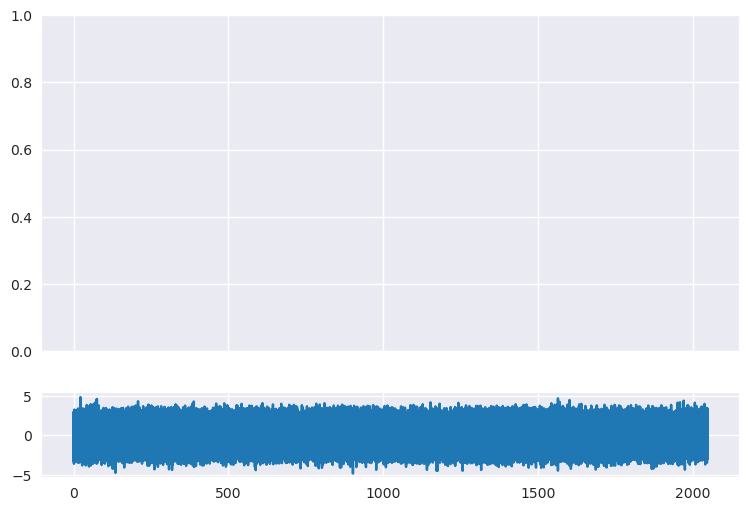

In [ ]:
nStationsAvg=0
randomstation =[]
fPosEP = np.zeros((fs.size, ntsums, nThreshs, ndates, nTrials)) #Initiallizes array for excess power false positives
fPosCoin = np.zeros((fs.size, ntsums, nThreshs, ndates, nTrials))
fPosP = np.zeros((fs.size, ntsums, nThreshs, ndates, nTrials)) #Initiallizes array for excess power & p-check false positives

#Each interation of nTrials uses a different ordering of the stations to randomize the time shifting
for z in range(nTrials):
#     print ("\n\n trial #", z)
    startStamp = datetime.now().strftime("%H:%M:%S") 
    #Load Time Shuffled Data
    datalist, sanitylist, fullUncList, fullSpinCorrList, fullBandCorrList, stations, nStationsAvg, startTimes, endTimes = LoadTimeShuffled( 
                                                                                              ndates,
                                                                                              fullStationList,
                                                                                              fullUnc,
                                                                                              fullSpinCorr,
                                                                                              fullBandCorr,
                                                                                              nStationsAvg,
                                                                                              realDataA = RealData,
                                                                                              timeShiftA = False
                                                                                            )
    print("Here are the data")
    print(datalist)
    print(sanitylist)
    print(fullUncList)
    print(fullSpinCorrList)
    print(fullBandCorrList)
   



    #Generate the threshold for different number of tiles summed assuming some desired confidence level, beta. 
    # and a Gaussian distribution. This is the threshold for the initial pass through the normalized spectrograms.
    # The sigma is just used to set the initial guess for finding the roots. The beta sets the confidence level.
    threshold0s = np.array([calculatecutoff(dofA = 2.*t*chanPerTile, 
                                            NstA = nStationsAvg, 
                                            nCoinA = nCoin, 
                                            betaA = beta, 
                                            sigmaA = sigma) 
                            for t in tsums])

    #Generates the thresholds at which to calculate the false probability based on max and min thresholds.
    thresholds = np.zeros((ntsums, nThreshs))
    for i,n in enumerate(np.arange(imint,imaxt+1,1)):
        thresholdmax = thresholdmaxs[n]
        thresholdmin = thresholdmins[n]
        thresholds[i,:] = np.linspace(thresholdmin, thresholdmax, nThreshs)

    #Loop over the number of time windows
    for j in range(0, ndates): 
        
        startStamp2 = datetime.now().strftime("%H:%M:%S") 
        
        #Determine the number of active stations
        print(stations)
        active = stations[j].compressed()
        nStations = active.size

            
        dataDelete, sanityDelete = GenerateNoise(TLimit, a = 10.0)
        for i,station in enumerate(active):
            if station == "0001":
                datalist[j][i] = TimeSeries(dataDelete, sample_rate = FSamp)    

        
        activeUnc = np.copy(fullUncList[np.nonzero(stations[j].mask*(-1)+1)])
        activeSpinCorr = np.copy(fullSpinCorrList[np.nonzero(stations[j].mask*(-1)+1)])
        activeBwNnorm = np.copy(fullBandCorrList[np.nonzero(stations[j].mask*(-1)+1)])

        #Initialize the arrays of spectrograms. The elements of the array correspond to the different stations
        SxxN = np.empty(nStations, dtype = np.ndarray) #Normalized Spectrogram
        Mnu0 = np.empty(nStations, dtype = np.ndarray) #"Up" Frequency Summed Spectrogram
        Mnd0 = np.empty(nStations, dtype = np.ndarray) #"Down" Frequency Summed Spectrogram
        MnND = np.empty(nStations, dtype = np.ndarray) #Unnormalized Spectrogram
        
        
        MnSU = np.empty(nStations, dtype = np.ndarray)  #"Up" Subracted Spectrogram
        MnSD = np.empty(nStations, dtype = np.ndarray)  #"Down" Subracted Spectrogram
        MnNSU = np.empty(nStations, dtype = np.ndarray) #"Up" Unsubracted Spectrogram
        MnNSD = np.empty(nStations, dtype = np.ndarray) #"Down" Unsubracted Spectrogram
        
        segPerTileStart = np.ceil(segPerTileMin/2.)

        #Generate unnormalized and normalized initial spectrograms.
        #The time tile size is equal to 1/2 the min time tile or the min tile size, deltaTMin
        #No frequency channels are summed
        #MnND is unnormalized spectrogram, SxxN is the normalized spectrogram
        for i,station in enumerate(active):
            MnND[i], SxxN[i] =  EP0(datalist[j][i],
                                    segments_per_tile = segPerTileStart,
                                    channels_per_tile = 1/int(deltaTMin),
                                    deltaTMinA = int(deltaTMin),
                                    ep_station = active[i],
                                    makeplot = True,
                                    show_intermediate = False
                                   )

    ############################################################  
    ############################################################
        tTileWidth = deltaTMin*segPerTileStart
        
        #Loop through all of the tile sum combinations being considered
        for n, segPerTile in enumerate(tsums): 
            tTileWidthPrev = tTileWidth
            tTileWidth = segPerTile*deltaTMin
            numberTtiles = int(np.round(TLimit/tTileWidth))

#              begin excess power (EPI)
#             "starting excess power analysis...generating summed spectrograms"

            if segPerTile>1:
                tempS = 2
            else:
                tempS = 1           
            
            #Loop through the active stations
            for i,station in enumerate(active):
                #Calculate the normailized and unnormalized spectrograms for the different time tile sums.
                #The frequency channels are summed with two combination, one starting at index 0 ("Up") and the other
                # at index 1 ("Down") so that the gaps between frequency channels are covered.
                # Mnu0 is the normalized "up" spectrogram, Mnd0 is the "down" spectrogram
                # MnND is the unnormalized spectrogram with no frequency summing
                # SxxN is the Normalized spectrogram with no frequency summing
                
                Mnu0[i], Mnd0[i], MnND[i], SxxN[i] = EPI(datalist[j][i],
                                                          MnND[i],
                                                          SxxN[i],
                                                          segments_per_tile = tempS,
                                                          channels_per_tile = chanPerTile,
                                                          deltaTMinA = tTileWidthPrev,
                                                          deltaFmin = 1./deltaTMin,
                                                          ep_station = station,
                                                          makeplot = False,
                                                          show_intermediate = False
                                                         )
##################################################

            #Pick out the threshold for the number of tiles summed
            threshold0 = threshold0s[n]

            shapeU = Mnu0[0].shape
            shapeD = Mnd0[0].shape       
           
            #Initialize the time-freq arrays that record the number of stations above the threshold for 
            # both the "up" and "down" spectrograms
            nStaAboveThreshU0 = np.zeros(shapeU)
            nStaAboveThreshD0 = np.zeros(shapeD)
            
            #For each station, add 1 for every station with EP above threshold0.
            #nStaAboveThreshU0 and nStaAboveThreshD0 are 2-D arrays with elements equal to the number of stations 
            # with EP above threshold0
            for i in range(0,nStations):
                nStaAboveThreshU0 += Mnu0[i] > threshold0           
                nStaAboveThreshD0 += Mnd0[i] > threshold0
                
            #If a given tile is flagged in more than nCoin stations, mask that tile to recalculate the average PSD
            # maskIndexU0 and maskIndexD0 are arrays of the indices of the flagged events for threshold0
            maskIndexU0 = np.nonzero(nStaAboveThreshU0 > nCoin-0.5)
            maskIndexD0 = np.nonzero(nStaAboveThreshD0 > nCoin-0.5)
            
            #Create a map of the time and frequency tiles that have more than nCoin stations above theshold0
            eventSpec0 = np.zeros(MnND[0].shape)
            eventSpec0 = np.copy(flagEvents(maskIndexU0, maskIndexD0, eventSpec0, chanPerTile))
            
            if PlotEventMaps:  
                plotEventMap(eventSpec0, TLimit, tTileWidth, 'Threshold0')            
                
            #Initialize spectrograms for determining when new events are no longer being flagged
            oldEventSpec = np.zeros(eventSpec0.shape)
            newEventSpec = np.copy(eventSpec0)
            loops = 0
            
###############################################################################################################
            #Go through procedure with threshold0. Repeat until no more events are flagged or a max of 4 times
            while np.any((oldEventSpec-newEventSpec)) and loops < 4:

#             while loops < 1:

                eventSpec0 = np.zeros(eventSpec0.shape)
                for i,station in enumerate(active):
                    #Calculate normalized spectrogram with the flagged events masked when calculating the average PSD
                    # Mnu0 and Mnd0 are the "up" and "down" spectrograms
                    Mnu0[i], Mnd0[i] = EPII(datalist[j][i],
                                            Sxx0 = MnND[i],
                                            deltaT = tTileWidth,
                                            fx = fs,
                                            Sxxmask = newEventSpec,
                                            segments_per_tile = segPerTile,
                                            channels_per_tile = chanPerTile,
                                            ep_station = station,
                                            show_intermediate = False,
                                            makeplot = False
                                           )

                nStaAboveThreshU0 = np.zeros(shapeU)
                nStaAboveThreshD0 = np.zeros(shapeD)

                #Find the tiles that have an excess power above threshold0
                for i in range(0,nStations):
                    nStaAboveThreshU0 += Mnu0[i] > threshold0
                    nStaAboveThreshD0 += Mnd0[i] > threshold0
                
                #If a given tile is flagged in more than nCoin stations, mask that tile to recalculate the average PSD.
                maskIndexU0 = np.nonzero(nStaAboveThreshU0 > nCoin - 0.5)
                maskIndexD0 = np.nonzero(nStaAboveThreshD0 > nCoin - 0.5)


                eventSpec0 = np.copy(flagEvents(maskIndexU0, maskIndexD0, eventSpec0, chanPerTile))
                oldEventSpec = np.copy(newEventSpec)
                newEventSpec = np.copy(eventSpec0)

                loops+=1
                
            if PlotEventMaps:  
                    plotEventMap(newEventSpec, TLimit, tTileWidth, 'II Thresh 0')
#############################################################################
            #Go through procedure again, using the predetermined thresholds
    
            
            #If a given tile is flagged in more than nCoin stations, mask that tile to recalculate the average PSD
            # maskIndexU and maskIndexD are arrays of the indices of the flagged events for threshold1
            
            maskIndexU = np.copy(maskIndexU0)
            maskIndexD = np.copy(maskIndexD0)
            
            for th, threshold1 in enumerate(thresholds[n]):
                if threshold1 > threshold0:
                    loopNum=10
                else:
                    loopNum=1
            
                
                # start EP II upper
                Mnu = np.copy(Mnu0)
                Mnd = np.copy(Mnd0)
                
#                 print("EPII upper threshold")        
                loops = 0
                eventSpec = np.zeros(eventSpec0.shape)
                oldEventSpec = np.zeros(eventSpec0.shape)                
                    
                while np.any((oldEventSpec-newEventSpec)) and loops < loopNum:


#                 newEventSpec = np.zeros(eventSpec0.shape)
#                 while loops < 1:
            
                    eventSpec = np.zeros(eventSpec0.shape)
                                    
                    for i,station in enumerate(active):
                        # Mnu and Mnd are the "up" and "down" spectrograms
                        Mnu[i], Mnd[i] = EPII(datalist[j][i],
                                              Sxx0 = MnND[i],
                                              deltaT = tTileWidth,
                                              fx = fs,
                                              Sxxmask = newEventSpec,
                                              segments_per_tile = segPerTile,
                                              channels_per_tile = chanPerTile,
                                              ep_station = station,
                                              show_intermediate = False,
                                              makeplot = True
                                             )
                        
                    #Generate a 2-D array with elements equal to the number of stations 
                    nStaAboveThreshU = np.zeros(shapeU)
                    nStaAboveThreshD = np.zeros(shapeD)

                    #Find the tiles that have an excess power above threshold0
                    for i in range(0,nStations):
                        #Find the tiles that have an excess power above threshold1
                        nStaAboveThreshU += Mnu[i] > threshold1
                        nStaAboveThreshD += Mnd[i] > threshold1   

                    #If a given tile is flagged in more than nCoin stations, mask that tile to recalculate the average PSD.
                    
                    maskIndexU = np.nonzero(nStaAboveThreshU > nCoin-0.5)
                    maskIndexD = np.nonzero(nStaAboveThreshD > nCoin-0.5)
                    
                    #Find the indices for the mask based on whether or not there were >= nCoin stations with flagged events
                    #The masking map is made using the minimum frequency channel 
                    
                    eventSpec = np.copy(flagEvents(maskIndexU, maskIndexD, eventSpec, chanPerTile))
                                        
                    oldEventSpec = np.copy(newEventSpec)
                    newEventSpec = np.copy(eventSpec)
                    
                    loops+=1

                if PlotEventMaps:
                    plotEventMap(newEventSpec, TLimit, tTileWidth, 'II Thresh 1')
                
                nEventsU = maskIndexU[0].size
                nEventsD = maskIndexD[0].size
                nEvents  = nEventsU + nEventsD
                
#               Assign the false positive probability for the given timesum, window, trial threshold and frequency 

#                  for up spectrogram
                for f in maskIndexU[0]:
                    fPosEP[2*f, n, th, j, z]   += float(1.0)/float(numberTtiles)
#                  for down spectrogram
                for f in maskIndexD[0]:
                    fPosEP[2*f+1, n, th, j, z] += float(1.0)/float(numberTtiles)
            
            
                #Initialize events arrays. 
                #eventsU is a 2-D array containing the EP values of the flagged tiles from the subtracted "up" spectrogram for each station
                #eventsNSU is a 2-D array containing the EP values of the flagged tiles from the unsubtracted "down" spectrogram for each station
                eventsU = np.zeros((nStations, nEventsU))
                eventsD = np.zeros((nStations, nEventsD))
                eventsNSU = np.zeros(eventsU.shape)
                eventsNSD = np.zeros(eventsD.shape)
                
                specMask = np.zeros(eventSpec0.shape)
                
                if threshold1 < threshold0:
                    specMask = np.copy(eventSpec0)
                else:
                    specMask = np.copy(eventSpec)
                
                for i,station in enumerate(active):
                    #EPIII returns the unsubtracted and subtraced spectrograms.
                    #MnSu,MnSd are arrays of the subtracted "up" and "down" spectrograms 
                    #MnNSu,MnNSd are arrays of not subtracted and not normalized "up" and "down"  spectrograms
                    MnSU[i], MnSD[i], MnNSU[i], MnNSD[i]    =  EPIII(Sxx = MnND[i],
                                                                     deltaT = tTileWidth,
                                                                     fx = fs,
                                                                     Sxxmask = specMask,
                                                                     segments_per_tile = segPerTile,
                                                                     channels_per_tile = chanPerTile,
                                                                     ep_station = station,
                                                                     show_intermediate = False,
                                                                     makeplot = False,
                                                                     subtract = False
                                                                    )   
                        
#                     for k in range (MnSu[i][0].size):
#                         MnSu[i][:,k] /= active_bwnorm[i][fxup.astype(int)-1]**2
#                         MnSd[i][:,k] /= active_bwnorm[i][fxdn.astype(int)-1]**2
                        
#                     MnSu[i] /= active_unc_spin[i]
#                     MnSd[i] /= active_unc_spin[i]
                    
                    #print("Mask Index U", maskIndexU)
                    print("Number of Active Stations", nStations)
                    eventsU[i]   = (MnSU[i])[maskIndexU]
                    eventsD[i]   = (MnSD[i])[maskIndexD]
                    eventsNSU[i] = (MnNSU[i])[maskIndexU]
                    eventsNSD[i] = (MnNSD[i])[maskIndexD]
                                                        

                #Use the standard deviation of the unflagged events from threshold0 to calculate uncertainties if 
                #threshold1 < threshold0.
                

                    
                if threshold1 < threshold0:
                    stdDevEventsU = np.copy(calculateEventUnc(nStations, MnNSU, maskIndexU0, eventsNSU, nEventsU, maskIndexU))
                    stdDevEventsD = np.copy(calculateEventUnc(nStations, MnNSD, maskIndexD0, eventsNSD, nEventsD, maskIndexD))
                else:
                    stdDevEventsU = np.copy(calculateEventUnc(nStations, MnNSU, maskIndexU, eventsNSU, nEventsU, maskIndexU))
                    stdDevEventsD = np.copy(calculateEventUnc(nStations, MnNSD, maskIndexD, eventsNSD, nEventsD, maskIndexD))

                consistency(active, stdDevEventsU, eventsU, maskIndexU, nEventsU, activeUnc, Mnu, threshold1,th)
                consistency(active, stdDevEventsD, eventsD, maskIndexD, nEventsD, activeUnc, Mnd, threshold1,th)



#                 for f in CoinSpectU[0]:
#                     fPosCoin[2*f, n, th, j, z] += 1.0/float(numberTtiles)  
#                 for f in CoinSpectD[0]:
#                     fPosCoin[2*f+1, n, th, j, z] += 1.0/float(numberTtiles)  
                
                
#                 for f in pFinalSpectU[0]:
#                     fPosP[2*f, n, th, j, z] += 1.0/float(numberTtiles)  
#                 for f in pFinalSpectD[0]:
#                     fPosP[2*f+1, n, th, j, z] += 1.0/float(numberTtiles)  

                    
        stopStamp2 = datetime.now().strftime("%H:%M:%S")
        print (j," window,   time : ",(datetime.strptime(stopStamp2, "%H:%M:%S") - datetime.strptime(startStamp2, "%H:%M:%S")).seconds)
                    
    stopStamp = datetime.now().strftime("%H:%M:%S")
    print ("\n\n\n  trial time : ",(datetime.strptime(stopStamp, "%H:%M:%S") - datetime.strptime(startStamp, "%H:%M:%S")).seconds)

                   
                    
fPosProbEP = np.mean(fPosEP,axis=(-1,-2))
fPosProbCoin = np.mean(fPosCoin,axis=(-1,-2))
fPosProbP = np.mean(fPosP,axis=(-1,-2))


fPosAvgEP = np.mean(fPosProbEP,axis=0)
fPosAvgCoin = np.mean(fPosProbCoin,axis=0)
fPosAvgP = np.mean(fPosProbP,axis=0)




# False Positive Probability Plots

average of 1 2048 second intervals


<>:28: SyntaxWarning: invalid escape sequence '\D'
<>:30: SyntaxWarning: invalid escape sequence '\e'
<>:31: SyntaxWarning: invalid escape sequence '\e'
<>:50: SyntaxWarning: invalid escape sequence '\D'
<>:53: SyntaxWarning: invalid escape sequence '\e'
<>:54: SyntaxWarning: invalid escape sequence '\e'
<>:28: SyntaxWarning: invalid escape sequence '\D'
<>:30: SyntaxWarning: invalid escape sequence '\e'
<>:31: SyntaxWarning: invalid escape sequence '\e'
<>:50: SyntaxWarning: invalid escape sequence '\D'
<>:53: SyntaxWarning: invalid escape sequence '\e'
<>:54: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_12163/1883085274.py:28: SyntaxWarning: invalid escape sequence '\D'
  ax.legend(title = 'Time-Frequency volume \n ($\Delta T \Delta F$, $\Delta F = 2$ Hz):\n $\epsilon^*$:           $EventCoin$:             $p$: :', bbox_to_anchor=(1., 0.75, 1., .102), loc='upper left', ncol = 4)
/tmp/ipykernel_12163/1883085274.py:30: SyntaxWarning: invalid escape sequence '\e'
  ax.set_

NameError: name 'fPosAvgEP' is not defined

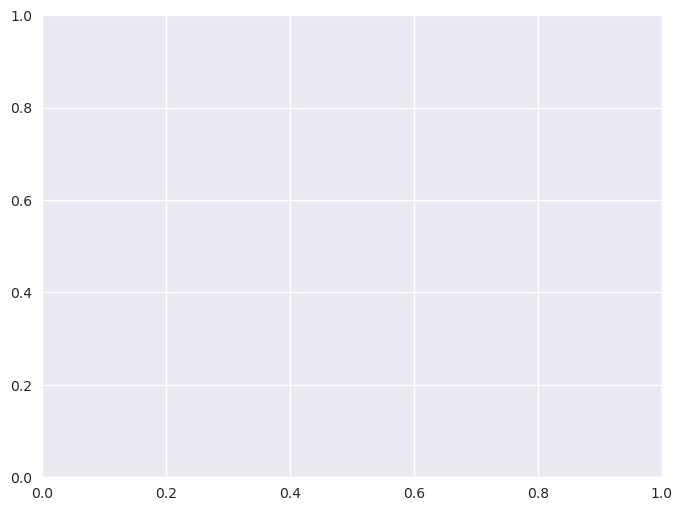

In [ ]:
q0vals = np.zeros((ntsums,nThreshs))
threshold1s = np.copy(thresholds)

cmap = plt.cm.tab20
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0., 1., 20)))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors1 = cycle[0::2]
colors2 = cycle[1::2]

print("average of {} {} second intervals".format(ndates, TLimit))
f2, ax = plt.subplots(1,figsize = (8,6))
for i in range(0,ntsums):
    ax.plot(thresholds[i],fPosAvgEP[i,:], 'o', color = colors1[i], label = '{}'.format(2*tsums[i])) 
    for j in range(nThreshs):
        q0vals[i,j] = (Q0(threshold1s[i,j], 2.*tsums[i]*deltaTMin*fTileWidth, nStationsAvg, nCoin))

for i in range(0,ntsums):
    ax.plot(thresholds[i],fPosAvgCoin[i,:], 'o', color = colors2[i], label = '{}'.format(2*tsums[i]))
            
for i in range(0,ntsums):
    ax.plot(thresholds[i],fPosAvgP[i,:], 'o', color = colors2[i], fillstyle = 'none', label = '{}'.format(2*tsums[i]))
    
# for i in range(0,ntsums):
#     ax.plot(thresholds[i],q0vals[i], color = colors1[i], label = '{}'.format(2*tsums[i]))


ax.set_title("False Positive Fraction (average {} {} s runs)".format(ndates,TLimit))
ax.legend(title = 'Time-Frequency volume \n ($\Delta T \Delta F$, $\Delta F = 2$ Hz):\n $\epsilon^*$:           $EventCoin$:             $p$: :', bbox_to_anchor=(1., 0.75, 1., .102), loc='upper left', ncol = 4)
  
ax.set_ylabel('$P_{N_{st},4}(\epsilon > \epsilon^*)$')
ax.set_xlabel('$\epsilon^*$')
plt.show()


f2, ax = plt.subplots(1,figsize = (8,6))
for i in range(0,ntsums):
    ax.plot(thresholds[i],fPosAvgEP[i,:], 'o', color = colors1[i], label = '{}'.format(2*tsums[i])) 

for i in range(0,ntsums):
    ax.plot(thresholds[i],fPosAvgCoin[i,:], 'o', color = colors2[i], label = '{}'.format(2*tsums[i]))
    
for i in range(0,ntsums):
    ax.plot(thresholds[i],fPosAvgP[i,:], 'o', color = colors2[i], fillstyle = 'none', label = '{}'.format(2*tsums[i]))
   
# for i in range(0,ntsums):
#     ax.plot(thresholds[i],q0vals[i], color = colors1[i], label = '{}'.format(2*tsums[i]))


ax.set_title("False Positive Fraction (average {} {} s runs)".format(ndates,TLimit))
ax.legend(title = 'Time-Frequency volume \n ($\Delta T \Delta F$, $\Delta F = 2$ Hz):\n $\epsilon^*$:           $EventCoin$:            $p$:', bbox_to_anchor=(1., 0.75, 1., .102), loc='upper left', ncol = 4)
ax.set_yscale('log', nonpositive = 'clip')
ax.set_ylim(10.**(-5),1.5)
ax.set_ylabel('$P_{N_{st},4}(\epsilon > \epsilon^*)$')
ax.set_xlabel('$\epsilon^*$')
plt.show()

In [ ]:
fPosAvgEP[i,:]

In [ ]:
# fPosAvgCoin[i,:]

In [ ]:
thresholds[n]


In [ ]:
plt.rcParams['font.size'] =14
EPbins=np.arange(0,1.1,0.1)
for th, threshold1 in enumerate(thresholds[n]):
    print(threshold1)

    
    f2, ax = plt.subplots(1,figsize = (8,6))
    ax.hist(pValueDist[th][1:],label = "$\chi^2$ Value")
#     ax.hist(pZeroValueDist[th][1:], bins = EPbins,alpha=0.5,label = "$p$ Value")
#     ax.set_title("$p$ and $p_0$ Value Distributions at $\epsilon^* $ of {}  $pT^2$".format(int(threshold1)) )
    ax.legend(bbox_to_anchor=(1., 0.75, 1., .102), loc='upper left', ncol = 1)
 

    ax.set_ylabel('Number of Events')
    ax.set_xlabel('p Value')


    plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_12163/1531685886.py:8: SyntaxWarning: invalid escape sequence '\c'
  ax.hist(pValueDist[th][1:],label = "$\chi^2$ Value")
/tmp/ipykernel_12163/1531685886.py:8: SyntaxWarning: invalid escape sequence '\c'
  ax.hist(pValueDist[th][1:],label = "$\chi^2$ Value")


IndexError: index 5 is out of bounds for axis 0 with size 1

In [ ]:
plt.rcParams['font.size'] =14
EPbins=np.arange(-4,4,0.05)
for th, threshold1 in enumerate(thresholds[n]):
    print(threshold1)

    
    f2, ax = plt.subplots(1,figsize = (8,6))
#     ax.hist(pValueDist[th][1:], bins = EPbins,label = "$\chi^2$ Value")
    ax.hist(pZeroValueDist[th][1:],bins = EPbins,alpha=0.5,label = "SpAvg/DelSp")

#     ax.set_title("$p$ and $p_0$ Value Distributions at $\epsilon^* $ of {}  $pT^2$".format(int(threshold1)) )
    ax.legend(bbox_to_anchor=(1., 0.75, 1., .102), loc='upper left', ncol = 1)
 

    ax.set_ylabel('Number of Events')
    ax.set_xlabel('<sP>/delta<sP>')


    plt.show()

IndexError: index 5 is out of bounds for axis 0 with size 1

In [ ]:
pZeroValueDist[th][1:].size

In [ ]:
maskIndexU[0].size+maskIndexD[0].size

In [ ]:
thresholds[n]

In [ ]:
filenum ="600"
runType = 'Gaussian'
folder = "saved_files/"+(datetime.now().strftime('%Y-%m-%d'))+"/{}".format(runType)
directory = '{}'.format(folder)
os.system('mkdir -p {}'.format(directory))



0

In [ ]:
for th, threshold1 in enumerate(thresholds[n]):

    dfPvalue = pd.DataFrame(data=pValueDist[th][1:])
    dfPvalue.to_csv("{}/{}FPosPvalue{}.csv".format(folder,filenum,th)) 

    dfMvalue = pd.DataFrame(data=pZeroValueDist[th][1:])
    dfMvalue.to_csv("{}/{}FPosMvalue{}.csv".format(folder,filenum,th)) 


In [ ]:
pZeroValueDist[0][1:]

In [ ]:
# maxlen =max([pZeroValueDist[th][1:].size for th, threshold1 in enumerate(thresholds[n]) ])

# maxlen=10